In [1]:
import argparse
import torch.nn as nn
import torch.nn.functional as F
import torch
import fastai
import fastai.vision
import time, copy
import core
import numpy as np
import pickle
from pathlib import Path

Epoch 1/2
----------
train Loss: 3.9266 Acc: 0.0445
val Loss: 3.4400 Acc: 0.0886
Epoch 2/2
----------
train Loss: 3.7160 Acc: 0.0661
val Loss: 3.3437 Acc: 0.1103
00:01:29
Epoch 1/1
----------
train Loss: 3.6664 Acc: 0.0715
val Loss: 3.3289 Acc: 0.1164
00:00:52
Epoch 1/1
----------
train Loss: 3.6245 Acc: 0.0729
val Loss: 3.3002 Acc: 0.1258
00:00:59
Epoch 1/2
----------
train Loss: 3.6279 Acc: 0.0749
val Loss: 3.3703 Acc: 0.0995
Epoch 2/2
----------
train Loss: 3.4466 Acc: 0.1003
val Loss: 3.1499 Acc: 0.1319
00:02:11
Epoch 1/3
----------
train Loss: 3.9236 Acc: 0.0458
val Loss: 3.4624 Acc: 0.0731
Epoch 2/3
----------
train Loss: 3.6978 Acc: 0.0631
val Loss: 3.3387 Acc: 0.1001
Epoch 3/3
----------
train Loss: 3.5718 Acc: 0.0820
val Loss: 3.2988 Acc: 0.1218
00:03:14
Epoch 1/3
----------
train Loss: 3.5799 Acc: 0.0778
val Loss: 3.3421 Acc: 0.0988
Epoch 2/3
----------
train Loss: 3.4713 Acc: 0.0880
val Loss: 3.1557 Acc: 0.1468
Epoch 3/3
----------
train Loss: 3.3255 Acc: 0.1116
val Loss: 3.

"To do... train both models for some point (based on stop criterion), splice, keep training till some point...\nthen save off the outputs! (You're almost done!)"

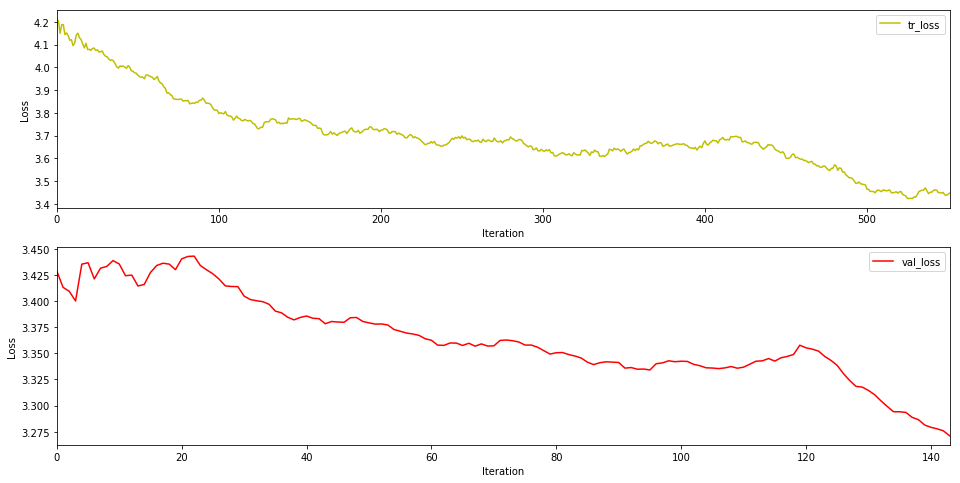

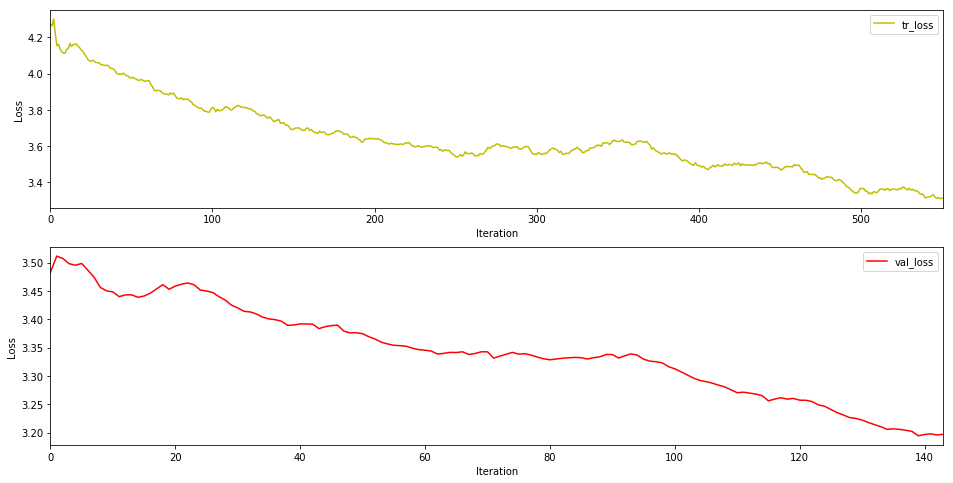

In [4]:
path = Path('experiments')
exp_path = path/'PETS_01'
config_path = exp_path/'config.pickle'

with open(config_path, 'rb') as handle:
    args = pickle.load(handle)

"Fetch the arguments based on the name of the experiment..."

ds = args['dataset']
image_size = args['image_size']
batchsize = args['batch_size']
initial_splice = args['initial_splice']
splice = args['splice']
early_stop = args['early_stop']
stop_pct = args['stop_percent']
seed = args['seed']
save = args['save']
max_lr = args['max_lr']
num_epochs = 2

torch.manual_seed(seed)
np.random.seed(seed)

"""Loads in the data..."""

if ds == 'CIFAR10':
    url = fastai.datasets.URLs.CIFAR
    path = fastai.datasets.untar_data(url)
    data = (fastai.vision.ImageItemList.from_folder(path)
            .split_by_folder(train='train', valid='test')
            .label_from_folder()
            .transform(fastai.vision.get_transforms(), size=image_size)
            .databunch(bs=batchsize))
    
elif ds == 'MNIST':
    url = fastai.datasets.URLs.MNIST
    path = fastai.datasets.untar_data(url)
    data = fastai.vision.ImageDataBunch.from_folder(path, train='training', valid='testing', bs=batchsize)
    
elif ds == 'PETS':
    func = lambda x: str(x)[46:].rstrip('.jpg1234567890').rstrip('_')
    url = fastai.datasets.URLs.PETS
    path = fastai.datasets.untar_data(url)
    data = (fastai.vision.ImageItemList.from_folder(path/'images')
            .random_split_by_pct()
            .label_from_func(func)
            .transform(fastai.vision.get_transforms(), size=image_size)
            .databunch(bs=batchsize))

else:
    raise('You must select a valid dataset for this experiment.')
    
crit = nn.CrossEntropyLoss()
dls = {'train':data.train_dl, 'val':data.valid_dl}

base_model = core.cnn(nc=data.c).cuda()
for nf, b_idx, i_idx in initial_splice:
    base_model.splice(nf=nf, b_idx=b_idx, i_idx=i_idx)
base_model.init_params()
base_model.init_opts(max_lr = max_lr, pct_start = 0.10)

comp_model = copy.deepcopy(base_model)
for nf, b_idx, i_idx in splice: 
    comp_model.splice(nf=nf, b_idx=b_idx, i_idx=i_idx)
    
comp_model.init_params()
comp_model.init_opts(max_lr = max_lr, pct_start=0.10)
    
base_model.fit(crit, dls, num_epochs=num_epochs, stop_on_plateau = early_stop, stop_percent = stop_pct)
for nf, b_idx, i_idx in splice:
    base_model.splice(nf=nf, b_idx=b_idx, i_idx=i_idx)
    base_model.fit(crit, dls, num_epochs=1, stop_on_plateau = False)
base_model.init_opts(pct_start = 0.10)
base_model.fit(crit, dls, num_epochs=num_epochs, stop_on_plateau=early_stop, stop_percent=stop_pct)
    
comp_model.fit(crit, dls, num_epochs=num_epochs+1, stop_on_plateau=early_stop, stop_percent=stop_pct)
comp_model.fit(crit, dls, num_epochs=num_epochs+1, stop_on_plateau=early_stop, stop_percent=stop_pct)

tr_hist, val_hist = base_model.process_history()
comp_tr_hist, comp_val_hist = comp_model.process_history()

tr_hist.to_csv(exp_path/'base_tr_hist.csv',index=False)
val_hist.to_csv(exp_path/'base_val_hist.csv',index=False)

comp_tr_hist.to_csv(exp_path/'comp_tr_hist.csv',index=False)
comp_val_hist.to_csv(exp_path/'comp_tr_hist.csv',index=False)

base_model.plot_history(save=exp_path/'base_history.png')
comp_model.plot_history(save=exp_path/'comp_history.png')

if save: 
    torch.save(base_model, exp_path/'base_model.pkl')
    torch.save(comp_model, exp_path/'comp_model.pkl')
    
"""To do... train both models for some point (based on stop criterion), splice, keep training till some point...
then save off the outputs! (You're almost done!)"""


In [5]:
comp_tr_hist.head()

AttributeError: 'LazyConfigValue' object has no attribute 'lower'

   iteration   tr_loss
0          0  4.272635
1          1  4.262589
2          2  4.301813
3          3  4.219232
4          4  4.153611

In [7]:
tr_hist.head()

AttributeError: 'LazyConfigValue' object has no attribute 'lower'

   iteration   tr_loss
0          0  4.213223
1          1  4.202611
2          2  4.149700
3          3  4.187706
4          4  4.188126

In [10]:
tr_hist = pd.merge(tr_hist, comp_tr_hist, left_on='iteration', right_on='iteration', how='outer')

In [9]:
import pandas as pd

In [11]:
tr_hist.head()

AttributeError: 'LazyConfigValue' object has no attribute 'lower'

   iteration  tr_loss_x  tr_loss_y
0          0   4.213223   4.272635
1          1   4.202611   4.262589
2          2   4.149700   4.301813
3          3   4.187706   4.219232
4          4   4.188126   4.153611

In [12]:
tr_hist.columns = ['iteration', 'spliced_model', 'unspliced_model']

In [20]:
def plot_loss_comparison(x,y, save=None):
    x.columns = ['iteration', 'spliced_model', 'unspliced_model']
    y.columns = ['iteration', 'spliced_model', 'unspliced_model']
    fig, ax = plt.subplots(2,1, figsize=(16,8))
    x.spliced_model.plot.line(ax=ax[0], color='y')
    x.unspliced_model.plot.line(ax=ax[0], color='r')
    y.spliced_model.plot.line(ax=ax[1], color='y')
    y.unspliced_model.plot.line(ax=ax[1], color='r')
    ax[0].set_xlabel('Iteration')
    ax[0].set_ylabel('Training Loss')
    ax[1].set_xlabel('Iteration')
    ax[1].set_ylabel('Validation Loss')
    
    
    if save is not None:
        plt.savefig(save)
    
    ax[0].legend()
    ax[1].legend()
    
    return None

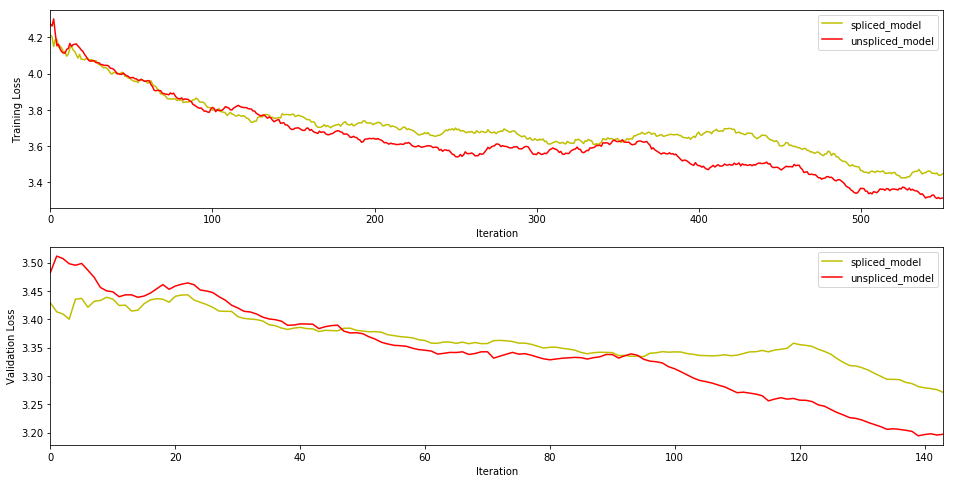

In [21]:
plot_loss_comparison(tr_hist, val_hist)